**CURSO**: *Machine Learning* en Geociencias<br />
**Profesor**: Edier Aristizábal (evaristizabalg@unal.edu.co) <br />
**Credits**: The content of this notebook is taken from several sources: Soner Yıldırım, Bex T, Manuel Hupperich, Youssef Hosni and Piero Paialunga en www.towardsdatascience.com. Every effort has been made to trace copyright holders of the materials used in this book. The author apologies for any unintentional omissions and would be pleased to add an acknowledgment in future editions.

# Time Series Analysis

In [ ]:
time_series_data = pd.read_csv('G:/My Drive/CATEDRA/MACHINE LEARNING/MachineLearning/data/temperature.csv', parse_dates=['datetime'], index_col='datetime')
city_data = pd.read_csv('G:/My Drive/CATEDRA/MACHINE LEARNING/MachineLearning/data/city_attributes.csv')
cities_list = city_data.City.tolist()
ts = time_series_data.dropna().reset_index()
ts['datetime'] = pd.to_datetime(ts['datetime'])
ts.head()

,datetime,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
0,2012-10-01 13:00:00,284.630000,282.080000,289.480000,281.800000,291.870000,291.530000,293.410000,296.600000,285.120000,...,285.630000,288.220000,285.830000,287.170000,307.590000,305.470000,310.580000,304.4,304.4,303.5
1,2012-10-01 14:00:00,284.629041,282.083252,289.474993,281.797217,291.868186,291.533501,293.403141,296.608509,285.154558,...,285.663208,288.247676,285.834650,287.186092,307.590000,304.310000,310.495769,304.4,304.4,303.5
2,2012-10-01 15:00:00,284.626998,282.091866,289.460618,281.789833,291.862844,291.543355,293.392177,296.631487,285.233952,...,285.756824,288.326940,285.847790,287.231672,307.391513,304.281841,310.411538,304.4,304.4,303.5
3,2012-10-01 16:00:00,284.624955,282.100481,289.446243,281.782449,291.857503,291.553209,293.381213,296.654466,285.313345,...,285.850440,288.406203,285.860929,287.277251,307.145200,304.238015,310.327308,304.4,304.4,303.5
4,2012-10-01 17:00:00,284.622911,282.109095,289.431869,281.775065,291.852162,291.563063,293.370249,296.677445,285.392738,...,285.944057,288.485467,285.874069,287.322831,306.898887,304.194188,310.243077,304.4,304.4,303.5


### Normalized

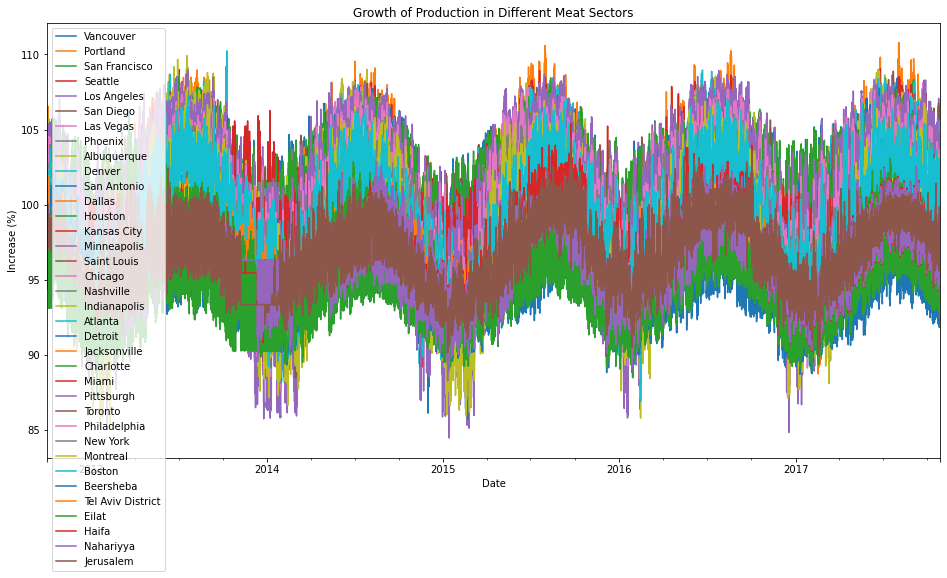

In [ ]:
tsh=ts.set_index("datetime").asfreq("1h")
normalized = tsh.div(tsh.iloc[0]).mul(100)  # Multiply by 100 to get percentages

normalized.plot(figsize=(16, 8), 
    title="Growth of Production in Different Meat Sectors")
plt.xlabel("Date")
plt.ylabel("Increase (%)");

### Correlation

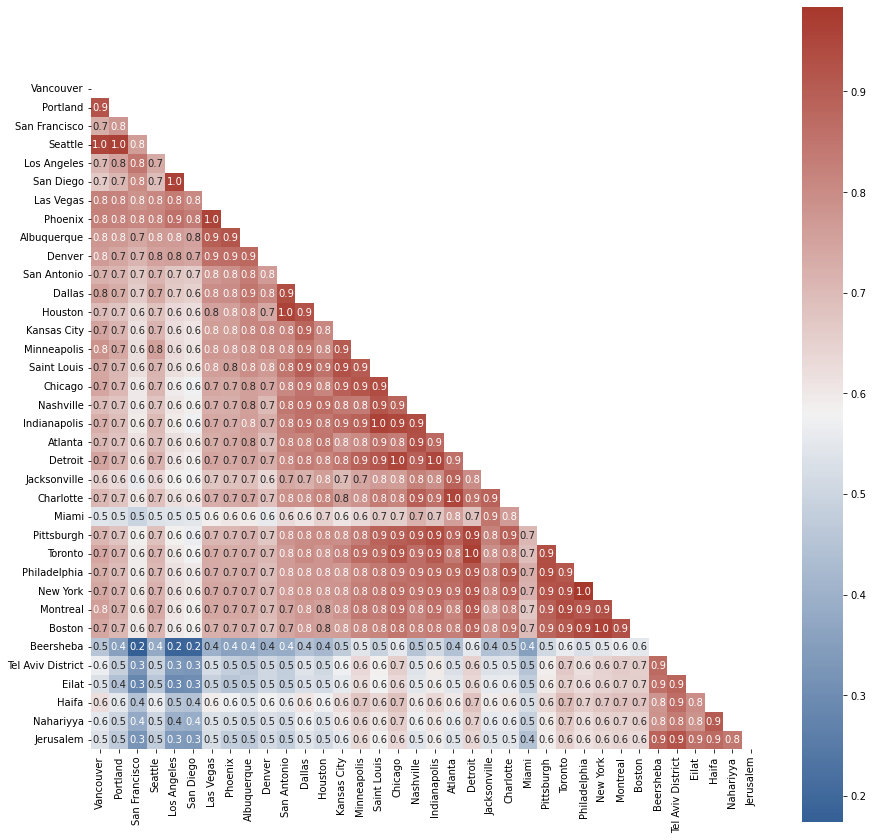

In [ ]:

# Create a custom palette
cmap = sns.diverging_palette(250, 15, s=75, l=40, n=9, center="light", as_cmap=True)

# Compute corr matrix
matrix = tsh.corr(method="pearson")
# Create a mask
mask = np.triu(np.ones_like(matrix, dtype=bool))

fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(matrix, mask=mask, cmap=cmap, square=True, annot=True, fmt=".1f", ax=ax)
plt.show();

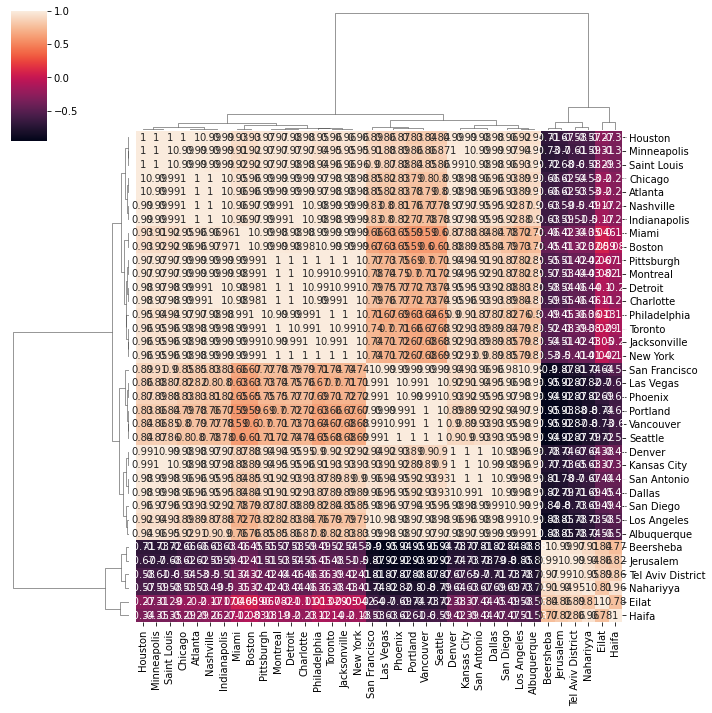

In [ ]:
seasonality_dict = {
    ts: seasonal_decompose(tsh[ts].dropna(), period=24).seasonal for ts in tsh.columns
}

# Compute corr matrix
seasonality_corr = pd.DataFrame(seasonality_dict).corr()
sns.clustermap(seasonality_corr, annot=True)
plt.show();

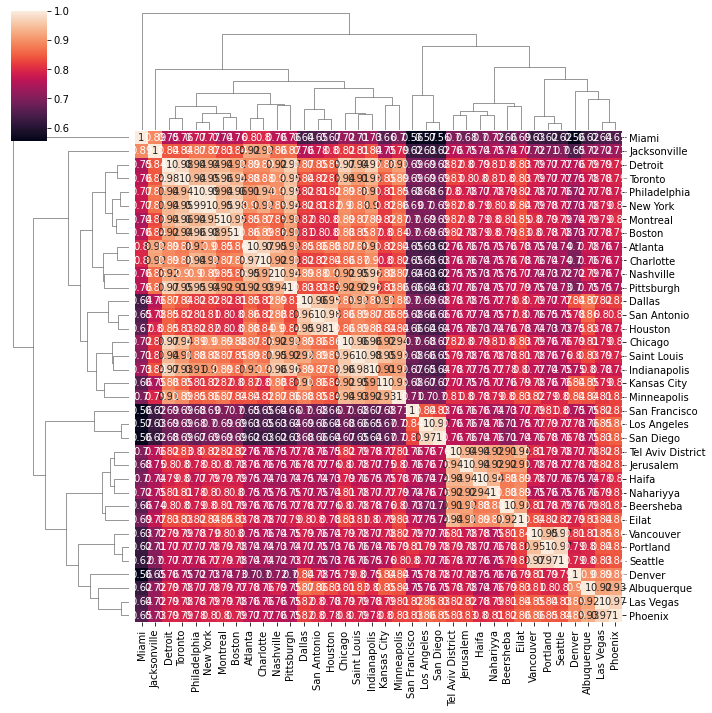

In [ ]:
trend_dict = {
    ts: seasonal_decompose(tsh[ts].dropna(), period=24).trend for ts in tsh.columns
}

# Compute corr matrix
trend_corr = pd.DataFrame(trend_dict).corr()
sns.clustermap(trend_corr, annot=True)
plt.show();

In [ ]:

seasonality_dict = {
    ts: sm.tsa.seasonal_decompose(tsh[ts].dropna()).seasonal for ts in tsh.columns
}

# Compute corr matrix
seasonality_corr = pd.DataFrame(seasonality_dict).corr()

sns.clustermap(seasonality_corr, annot=True, square=True)
plt.show();

ValueError: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None

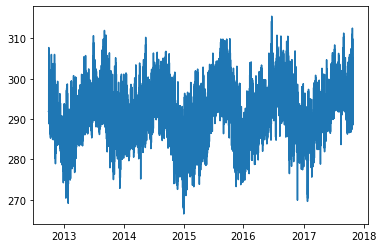

In [ ]:
cities_list = time_series_data.columns.tolist()[1:]
plt.plot(ts['datetime'],ts[cities_list[4]])

The time series are of course too messy for the algorithm we are using: it would take ages. Let’s undersample the dataset for our purpose:

In [ ]:
undersample_data = ts.loc[np.linspace(ts.index.min(),ts.index.max(),1500).astype(int)]
undersample_data = undersample_data.reset_index().drop('index',axis=1)

Text(0, 0.5, 'Temperature')

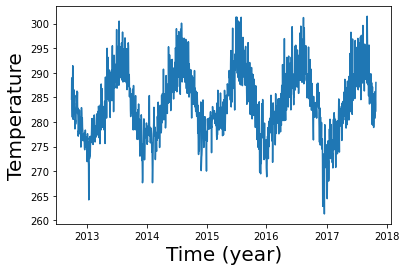

In [ ]:
plt.plot(undersample_data.datetime,undersample_data['Vancouver'])
plt.xlabel('Time (year)',fontsize=20)
plt.ylabel('Temperature',fontsize=20)

In [ ]:
from tslearn import metrics
data_array = np.array(undersample_data.T.drop('datetime').values)
from tslearn.clustering import TimeSeriesKMeans
model = TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=10)
model.fit(data_array)
cities_list = undersample_data.T.drop('datetime').index.tolist()

c:\Users\usuario\miniconda3\envs\geospatial\lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [ ]:
y=model.predict(data_array)

c:\Users\usuario\miniconda3\envs\geospatial\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 36 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


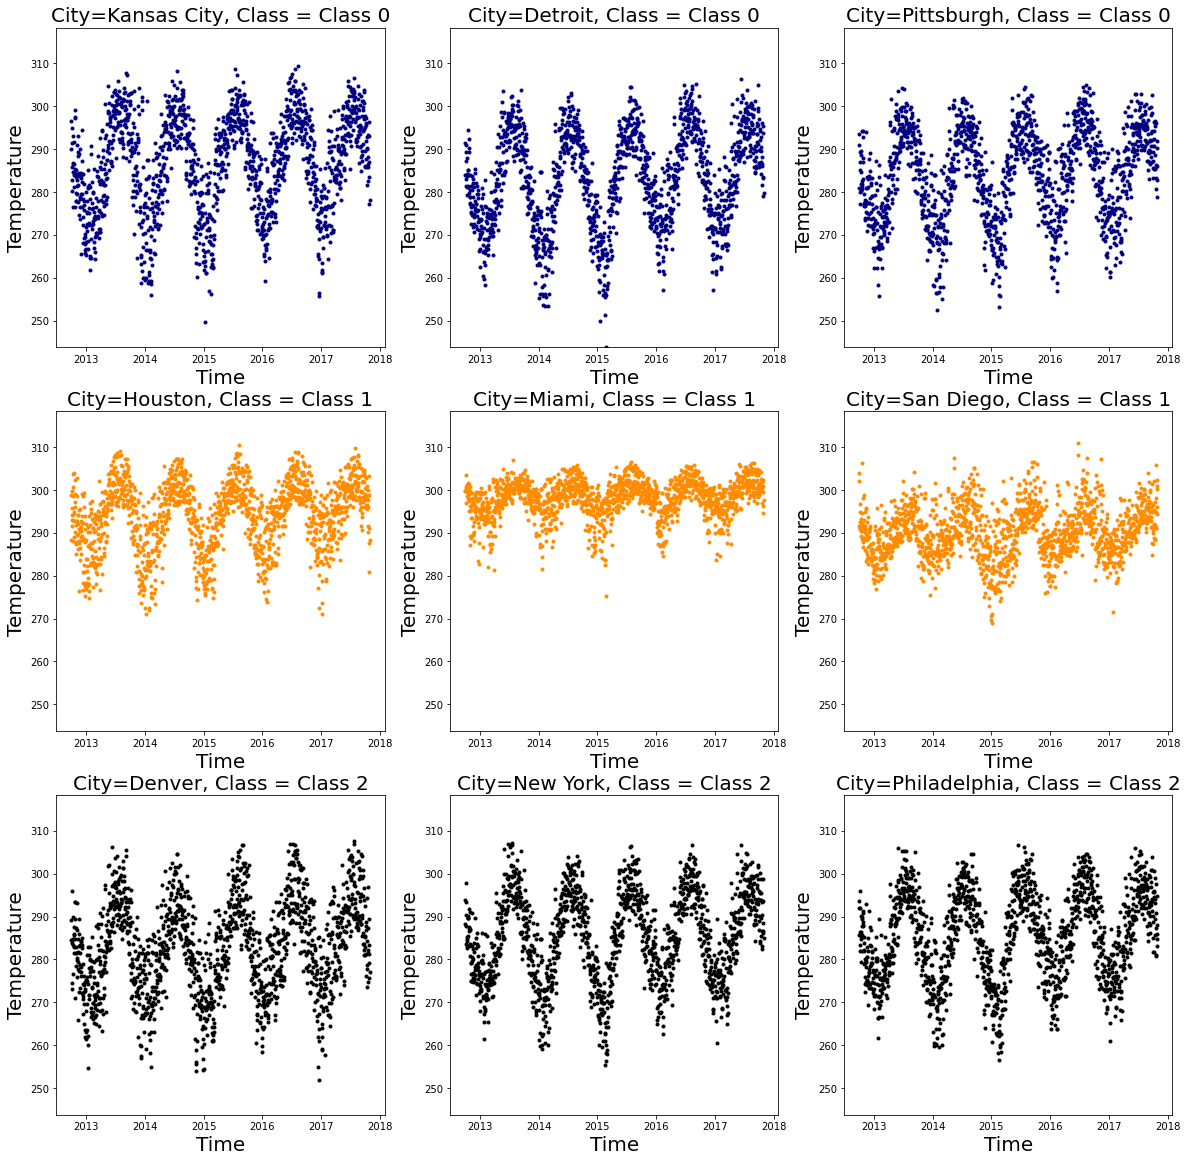

In [ ]:
x = undersample_data.datetime
plt.figure(figsize=(20,20))
k_dict = {'1':0,'2':0,'3':0,'4':1,'5':1,'6':1,'7':2,'8':2,'9':2}
colors = ['navy']*3+['darkorange']*3+['k']*3
Names = ['Class 0']*3+['Class 1']*3+['Class 2']*3
for j in range(1,10):
    plt.subplot(3,3,j)
    k = np.random.choice(np.where(y==k_dict[str(j)])[0])
    plt.plot(x,data_array[k],'.',color=colors[j-1])
    plt.ylabel('Temperature',fontsize=20)
    plt.xlabel('Time',fontsize=20)
    plt.title('City=%s, Class = %s'%(cities_list[k],Names[j-1]),fontsize=20)
    plt.ylim(data_array.min(),data_array.max())

* The first class has a wide range, but it seems to be always smaller or equal than 310. The lowest value seems to be, in general, around 260 (values around 250 seems to be outliers).
* The second class has shorter range but apparently larger value: both the lower and the larger value is larger than the correspondent ones of the first class
* The third class happens to be similar to the first one, but we have more values in the high temperature than what we have in the small temperature.

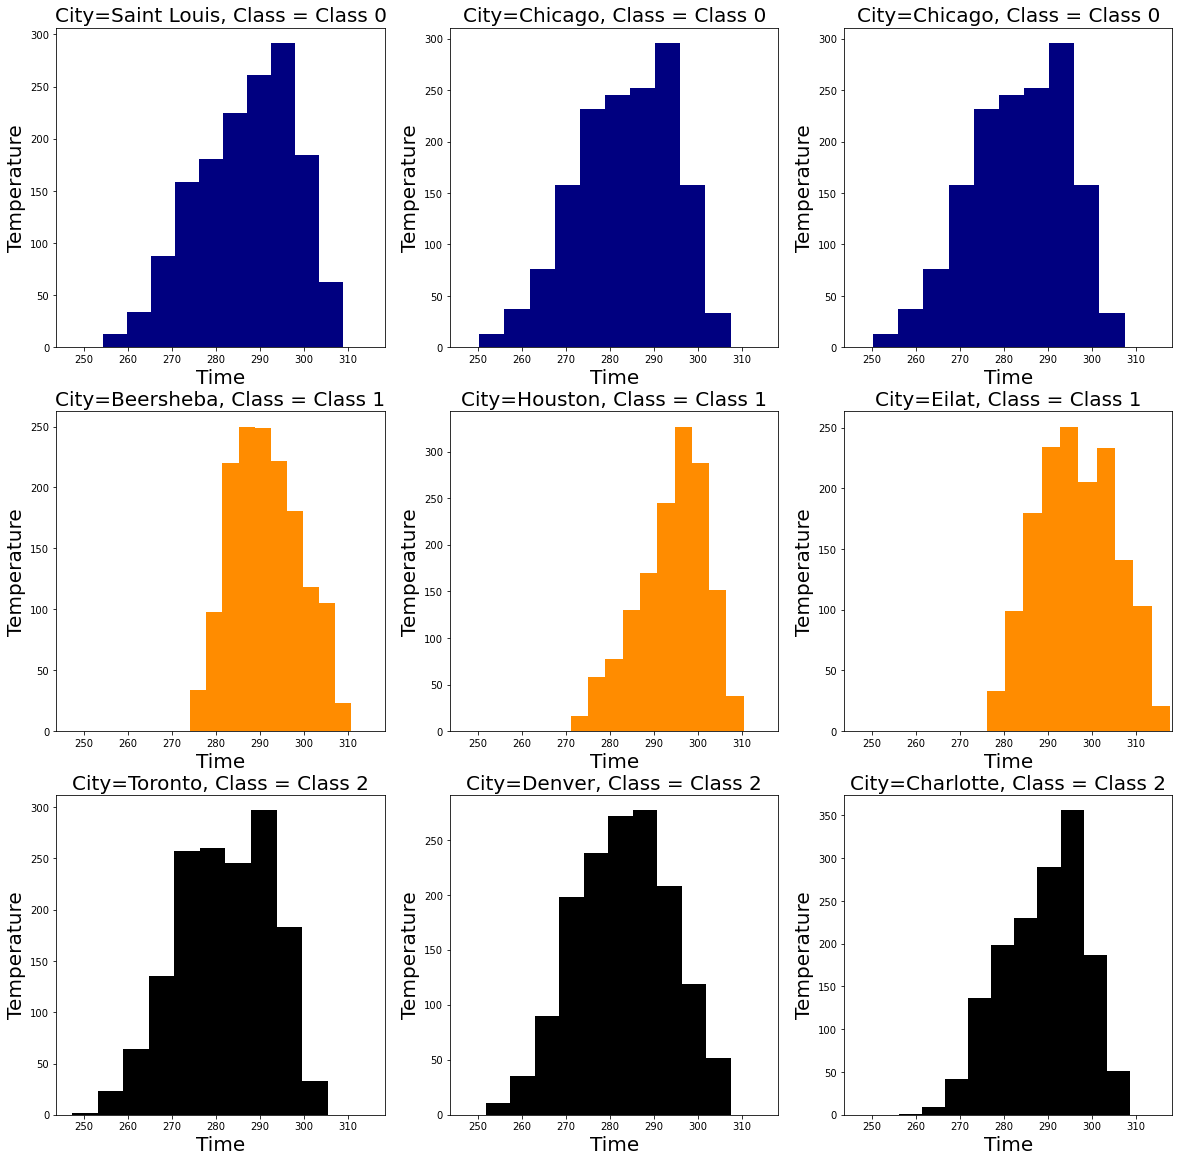

In [ ]:
plt.figure(figsize=(20,20))
k_dict = {'1':0,'2':0,'3':0,'4':1,'5':1,'6':1,'7':2,'8':2,'9':2}
colors = ['navy']*3+['darkorange']*3+['k']*3
Names = ['Class 0']*3+['Class 1']*3+['Class 2']*3
for j in range(1,10):
    plt.subplot(3,3,j)
    k = np.random.choice(np.where(y==k_dict[str(j)])[0])
    plt.hist(data_array[k],color=colors[j-1])
    plt.ylabel('Temperature',fontsize=20)
    plt.xlabel('Time',fontsize=20)
    plt.title('City=%s, Class = %s'%(cities_list[k],Names[j-1]),fontsize=20)
    plt.xlim(data_array.min(),data_array.max())

Why do we say that this is informative and not obvious? Well, because the cities appear to be similar in terms of trends and ranges but not really close in terms of location.
On the other hand, if you just do a K Means on the locations (like this):

In [ ]:
naive_data = city_data[['Latitude','Longitude']].reset_index().drop('index',axis=1)
from sklearn.cluster import KMeans
naive_k = KMeans(n_clusters=3).fit(X=naive_data).predict(naive_data)

<AxesSubplot:xlabel='Longitude', ylabel='Latitude'>

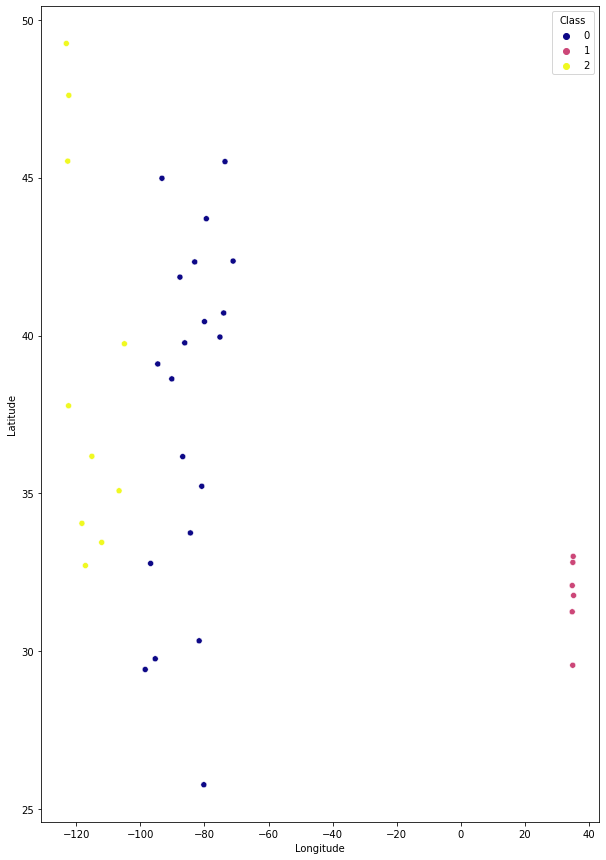

In [ ]:
import seaborn as sns
data_c = naive_data.copy()
data_c['Class']=naive_k
sns.scatterplot(x='Longitude',y='Latitude',hue='Class',data=data_c,palette='plasma')